In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define column names and columns to drop
columns = ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'TRA', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf',
           'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
drop_cols = ['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr']

# Process and combine all training datasets
train_data_processed = []
for i in range(1, 5):
    dataset_id = f'FD00{i}'
    
    # Read data
    train_df = pd.read_csv(f"train_{dataset_id}.txt", sep=" ", header=None)
    train_df.drop(columns=[26, 27], inplace=True)
    train_df.columns = columns
    
    # Drop unnecessary sensor columns
    train_df.drop(columns=drop_cols, inplace=True)
    
    # Add dataset_id column
    train_df['dataset_id'] = dataset_id
    
    # Calculate Life Ratio (from 0 at new to 1 at failure)
    eol = train_df.groupby('unit_number')['time_in_cycles'].transform('max')
    train_df['Life_ratio'] = train_df['time_in_cycles'] / eol
    
    train_data_processed.append(train_df)
    print(f"Processed train_{dataset_id}.txt, number of rows: {train_df.shape[0]}")

# Concatenate all training data into a single DataFrame
train_df_all = pd.concat(train_data_processed, ignore_index=True)

# Create a unique engine_id for each engine across all datasets
train_df_all['engine_id'] = train_df_all['dataset_id'].astype(str) + '_' + train_df_all['unit_number'].astype(str)

print("\nCombined Training Data Head:")
print(train_df_all.head())

Processed train_FD001.txt, number of rows: 20631
Processed train_FD002.txt, number of rows: 53759
Processed train_FD003.txt, number of rows: 24720
Processed train_FD004.txt, number of rows: 61249

Combined Training Data Head:
   unit_number  time_in_cycles  setting_1  setting_2     T24      T30  \
0            1               1    -0.0007    -0.0004  641.82  1589.70   
1            1               2     0.0019    -0.0003  642.15  1591.82   
2            1               3    -0.0043     0.0003  642.35  1587.99   
3            1               4     0.0007     0.0000  642.35  1582.79   
4            1               5    -0.0019    -0.0002  642.37  1582.85   

       T50    P15     P30       Nf  ...     phi      NRf      NRc     BPR  \
0  1400.60  21.61  554.36  2388.06  ...  521.66  2388.02  8138.62  8.4195   
1  1403.14  21.61  553.75  2388.04  ...  522.28  2388.07  8131.49  8.4318   
2  1404.20  21.61  554.26  2388.08  ...  522.42  2388.03  8133.23  8.4178   
3  1401.87  21.61  554.45  

In [3]:
# Process and combine all test datasets
test_data_processed = []
for i in range(1, 5):
    dataset_id = f'FD00{i}'
    
    # Read data
    test_df = pd.read_csv(f"test_{dataset_id}.txt", sep=" ", header=None)
    rul_df = pd.read_csv(f"RUL_{dataset_id}.txt", sep=" ", header=None)
    
    test_df.drop(columns=[26, 27], inplace=True)
    test_df.columns = columns
    
    # Drop unnecessary sensor columns
    test_df.drop(columns=drop_cols, inplace=True)
    
    # Add dataset_id column
    test_df['dataset_id'] = dataset_id
    
    # --- Corrected Life Ratio Calculation for Test Data ---
    # Get the max cycle for each engine in the test set
    max_cycles_test = test_df.groupby('unit_number')['time_in_cycles'].transform('max')
    
    # Map the final RUL values from rul_df to each engine in test_df
    final_rul = test_df['unit_number'].apply(lambda unit: rul_df.iloc[unit - 1, 0])
    
    # Calculate total life and then the Life Ratio
    total_life = max_cycles_test + final_rul
    test_df['Life_ratio'] = test_df['time_in_cycles'] / total_life
    
    test_data_processed.append(test_df)
    print(f"Processed test_{dataset_id}.txt, number of rows: {test_df.shape[0]}")

# Concatenate all test data into a single DataFrame
test_df_all = pd.concat(test_data_processed, ignore_index=True)

# Create a unique engine_id
test_df_all['engine_id'] = test_df_all['dataset_id'].astype(str) + '_' + test_df_all['unit_number'].astype(str)

# Keep an unscaled version for plotting later
test_df_unscaled = test_df_all.copy()

print("\nCombined Test Data Head:")
print(test_df_all.head())

Processed test_FD001.txt, number of rows: 13096
Processed test_FD002.txt, number of rows: 33991
Processed test_FD003.txt, number of rows: 16596
Processed test_FD004.txt, number of rows: 41214

Combined Test Data Head:
   unit_number  time_in_cycles  setting_1  setting_2     T24      T30  \
0            1               1     0.0023     0.0003  643.02  1585.29   
1            1               2    -0.0027    -0.0003  641.71  1588.45   
2            1               3     0.0003     0.0001  642.46  1586.94   
3            1               4     0.0042     0.0000  642.44  1584.12   
4            1               5     0.0014     0.0000  642.51  1587.19   

       T50    P15     P30       Nf  ...     phi      NRf      NRc     BPR  \
0  1398.21  21.61  553.90  2388.04  ...  521.72  2388.03  8125.55  8.4052   
1  1395.42  21.61  554.85  2388.01  ...  522.16  2388.06  8139.62  8.3803   
2  1401.34  21.61  554.11  2388.05  ...  521.97  2388.03  8130.10  8.4441   
3  1406.42  21.61  554.07  2388.03 

In [4]:
# Identify feature columns (excluding identifiers and the target)
feature_cols = [col for col in train_df_all.columns if col not in ['Life_ratio', 'dataset_id', 'engine_id', 'unit_number', 'time_in_cycles']]

# Initialize and fit the scaler on the training data
scaler = StandardScaler()
train_df_all[feature_cols] = scaler.fit_transform(train_df_all[feature_cols])

# Transform the test data using the same scaler
test_df_all[feature_cols] = scaler.transform(test_df_all[feature_cols])

print("Feature columns scaled:", feature_cols)
print("\nScaled Training Data Head:")
print(train_df_all.head())

Feature columns scaled: ['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

Scaled Training Data Head:
   unit_number  time_in_cycles  setting_1  setting_2       T24       T30  \
0            1               1  -1.041429  -1.115418  1.046626  1.037990   
1            1               2  -1.041272  -1.115146  1.054395  1.055929   
2            1               3  -1.041647  -1.113516  1.059103  1.023520   
3            1               4  -1.041344  -1.114331  1.059103  0.979517   
4            1               5  -1.041502  -1.114874  1.059574  0.980025   

        T50       P15       P30        Nf  ...       phi       NRf       NRc  \
0  1.024534  1.115018  1.117707  0.802032  ...  1.113752  0.345200  0.616065   
1  1.043169  1.115018  1.114204  0.801891  ...  1.117528  0.345649  0.527629   
2  1.050946  1.115018  1.117133  0.802172  ...  1.118380  0.345289  0.549211   
3  1.033851  1.115018  1.118224  0.8

In [5]:
def create_sequences(input_data, window_size):
    """Creates sequences from the time-series data."""
    X, y = [], []
    
    # Columns to use as features for the model
    model_feature_cols = [col for col in input_data.columns if col not in ['Life_ratio', 'dataset_id', 'engine_id']]

    for engine in tqdm(input_data['engine_id'].unique(), desc="Creating Sequences"):
        engine_data = input_data[input_data['engine_id'] == engine]
        
        # Ensure we only use the feature columns for X
        engine_features = engine_data[model_feature_cols].values
        engine_target = engine_data['Life_ratio'].values
        
        for i in range(len(engine_data) - window_size + 1):
            X.append(engine_features[i:i + window_size])
            y.append(engine_target[i + window_size - 1])
            
    return np.array(X), np.array(y)

# Define window size
win_len = 10

# Create sequences for training and testing
X_train, y_train = create_sequences(train_df_all, win_len)
X_test, y_test = create_sequences(test_df_all, win_len)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Creating Sequences: 100%|██████████| 707/707 [00:03<00:00, 226.29it/s]



X_train shape: (153978, 10, 19)
y_train shape: (153978,)
X_test shape: (98534, 10, 19)
y_test shape: (98534,)


In [6]:
# 1. Dataset class
class DegradationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].view(1)

# 2. Neural Network model (2D CNN)
class DegradationCNN2D(nn.Module):
    def __init__(self, num_features):
        super(DegradationCNN2D, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1) # -> (Batch, 1, Window, Features)
        x = self.cnn(x)
        x = self.regressor(x)
        return x

# 3. Dataset & Dataloader
train_dataset = DegradationDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = DegradationDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4. Training Setup
num_features = X_train.shape[2]
model = DegradationCNN2D(num_features).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# 5. Training Loop
epochs = 30
best_test_rmse = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for X_batch, y_batch in pbar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss/len(pbar)})
    
    # Evaluate on test data
    model.eval()
    all_preds = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch.to(device))
            all_preds.extend(outputs.cpu().numpy())
    
    test_preds = np.array(all_preds).flatten()
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.6f}, Test RMSE: {test_rmse:.6f}")

    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ New best model saved with Test RMSE: {best_test_rmse:.6f}")

Epoch 1/30: 100%|██████████| 2406/2406 [00:14<00:00, 168.60it/s, loss=0.0156] 


Epoch [1/30], Loss: 0.015592, Test RMSE: 0.121452
✅ New best model saved with Test RMSE: 0.121452


Epoch 2/30: 100%|██████████| 2406/2406 [00:13<00:00, 182.64it/s, loss=0.015]  


Epoch [2/30], Loss: 0.015011, Test RMSE: 0.105147
✅ New best model saved with Test RMSE: 0.105147


Epoch 3/30: 100%|██████████| 2406/2406 [00:13<00:00, 183.59it/s, loss=0.0135] 


Epoch [3/30], Loss: 0.013535, Test RMSE: 0.161951


Epoch 4/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.88it/s, loss=0.00991]


Epoch [4/30], Loss: 0.009913, Test RMSE: 0.145389


Epoch 5/30: 100%|██████████| 2406/2406 [00:13<00:00, 184.51it/s, loss=0.00798]


Epoch [5/30], Loss: 0.007978, Test RMSE: 0.206356


Epoch 6/30: 100%|██████████| 2406/2406 [00:12<00:00, 186.67it/s, loss=0.00712]


Epoch [6/30], Loss: 0.007125, Test RMSE: 0.082719
✅ New best model saved with Test RMSE: 0.082719


Epoch 7/30: 100%|██████████| 2406/2406 [00:12<00:00, 187.94it/s, loss=0.00651]


Epoch [7/30], Loss: 0.006513, Test RMSE: 0.083581


Epoch 8/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.73it/s, loss=0.00605]


Epoch [8/30], Loss: 0.006045, Test RMSE: 0.117558


Epoch 9/30: 100%|██████████| 2406/2406 [00:13<00:00, 184.52it/s, loss=0.00586]


Epoch [9/30], Loss: 0.005855, Test RMSE: 0.100151


Epoch 10/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.88it/s, loss=0.00568]


Epoch [10/30], Loss: 0.005683, Test RMSE: 0.078899
✅ New best model saved with Test RMSE: 0.078899


Epoch 11/30: 100%|██████████| 2406/2406 [00:12<00:00, 186.04it/s, loss=0.00553]


Epoch [11/30], Loss: 0.005533, Test RMSE: 0.139422


Epoch 12/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.92it/s, loss=0.00544]


Epoch [12/30], Loss: 0.005438, Test RMSE: 0.098169


Epoch 13/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.17it/s, loss=0.00537]


Epoch [13/30], Loss: 0.005370, Test RMSE: 0.087123


Epoch 14/30: 100%|██████████| 2406/2406 [00:12<00:00, 187.70it/s, loss=0.00522]


Epoch [14/30], Loss: 0.005222, Test RMSE: 0.105846


Epoch 15/30: 100%|██████████| 2406/2406 [00:13<00:00, 183.76it/s, loss=0.00515]


Epoch [15/30], Loss: 0.005151, Test RMSE: 0.075169
✅ New best model saved with Test RMSE: 0.075169


Epoch 16/30: 100%|██████████| 2406/2406 [00:13<00:00, 181.61it/s, loss=0.00513]


Epoch [16/30], Loss: 0.005134, Test RMSE: 0.076938


Epoch 17/30: 100%|██████████| 2406/2406 [00:13<00:00, 183.34it/s, loss=0.00505]


Epoch [17/30], Loss: 0.005047, Test RMSE: 0.081042


Epoch 18/30: 100%|██████████| 2406/2406 [00:12<00:00, 186.09it/s, loss=0.00497]


Epoch [18/30], Loss: 0.004970, Test RMSE: 0.075382


Epoch 19/30: 100%|██████████| 2406/2406 [00:13<00:00, 184.08it/s, loss=0.00498]


Epoch [19/30], Loss: 0.004979, Test RMSE: 0.083491


Epoch 20/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.57it/s, loss=0.00491]


Epoch [20/30], Loss: 0.004912, Test RMSE: 0.074419
✅ New best model saved with Test RMSE: 0.074419


Epoch 21/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.91it/s, loss=0.0049] 


Epoch [21/30], Loss: 0.004904, Test RMSE: 0.079023


Epoch 22/30: 100%|██████████| 2406/2406 [00:13<00:00, 173.09it/s, loss=0.00488]


Epoch [22/30], Loss: 0.004875, Test RMSE: 0.079841


Epoch 23/30: 100%|██████████| 2406/2406 [00:14<00:00, 161.08it/s, loss=0.00485]


Epoch [23/30], Loss: 0.004849, Test RMSE: 0.107609


Epoch 24/30: 100%|██████████| 2406/2406 [00:12<00:00, 185.71it/s, loss=0.00479]


Epoch [24/30], Loss: 0.004786, Test RMSE: 0.074676


Epoch 25/30: 100%|██████████| 2406/2406 [00:13<00:00, 185.03it/s, loss=0.00476]


Epoch [25/30], Loss: 0.004764, Test RMSE: 0.079318


Epoch 26/30: 100%|██████████| 2406/2406 [00:13<00:00, 184.41it/s, loss=0.00473]


Epoch [26/30], Loss: 0.004731, Test RMSE: 0.080651


Epoch 27/30: 100%|██████████| 2406/2406 [00:13<00:00, 184.44it/s, loss=0.00475]


Epoch [27/30], Loss: 0.004755, Test RMSE: 0.075529


Epoch 28/30: 100%|██████████| 2406/2406 [00:13<00:00, 184.25it/s, loss=0.00472]


Epoch [28/30], Loss: 0.004716, Test RMSE: 0.073923
✅ New best model saved with Test RMSE: 0.073923


Epoch 29/30: 100%|██████████| 2406/2406 [00:13<00:00, 180.35it/s, loss=0.00469]


Epoch [29/30], Loss: 0.004686, Test RMSE: 0.079787


Epoch 30/30: 100%|██████████| 2406/2406 [00:13<00:00, 184.84it/s, loss=0.00467]


Epoch [30/30], Loss: 0.004670, Test RMSE: 0.081803


C:\Users\rsree\AppData\Local\Temp\ipykernel_10908\2080504914.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Final Ev


--- Final Model Performance Evaluation ---
R-squared (R²) Score: 0.8959
Mean Squared Error (MSE): 0.005465
Root Mean Squared Error (RMSE): 0.073923
Mean Absolute Error (MAE): 0.055868
Custom Accuracy (10% Tolerance): 83.32%


Creating Sequences: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


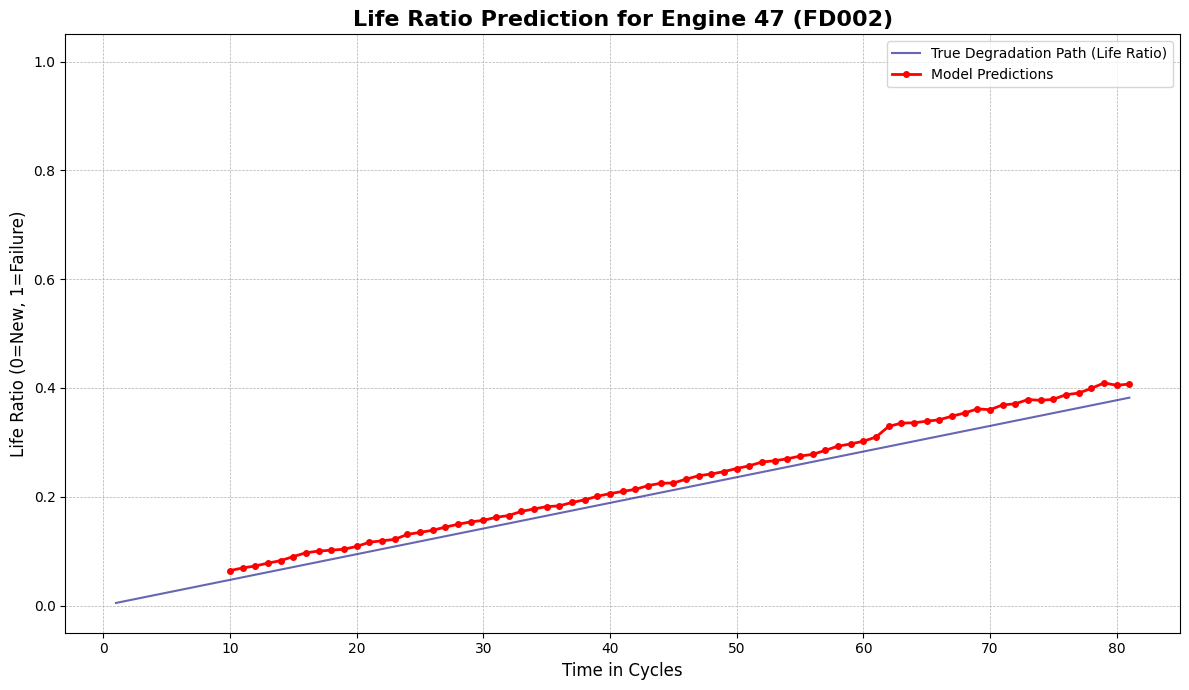

In [14]:


# Load the best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

# Get predictions on the entire test set
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc="Final Evaluation"):
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        all_predictions.append(outputs.cpu().numpy())
        all_true_labels.append(y_batch.numpy())

y_pred = np.concatenate(all_predictions).flatten()
y_true = np.concatenate(all_true_labels).flatten()

# --- Calculate All Metrics ---
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
custom_acc = np.mean(np.abs(y_pred - y_test) < 0.10) * 100 

print("\n--- Final Model Performance Evaluation ---")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Custom Accuracy (10% Tolerance): {custom_acc:.2f}%")


# --- Plotting a single engine ---
dataset_to_plot = 'FD002' 
unit_to_plot = 47
engine_id_to_plot = f"{dataset_to_plot}_{unit_to_plot}"

engine_data_scaled = test_df_all[test_df_all['engine_id'] == engine_id_to_plot]
engine_data_unscaled = test_df_unscaled[test_df_unscaled['engine_id'] == engine_id_to_plot]

if len(engine_data_scaled) >= win_len:
    X_engine, _ = create_sequences(engine_data_scaled, win_len)
    X_tensor = torch.tensor(X_engine, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        y_pred_engine = model(X_tensor).cpu().numpy().flatten()

    y_true_engine = engine_data_unscaled['Life_ratio'].values[win_len-1:]
    time_steps = engine_data_unscaled['time_in_cycles'].values[win_len-1:]

    plt.figure(figsize=(12, 7))
    plt.plot(engine_data_unscaled['time_in_cycles'], engine_data_unscaled['Life_ratio'], 
             label="True Degradation Path (Life Ratio)", color='navy', alpha=0.6)
    plt.plot(time_steps, y_pred_engine, 'ro-', 
             label="Model Predictions", markersize=4, linewidth=2)
    
    plt.title(f"Life Ratio Prediction for Engine {unit_to_plot} ({dataset_to_plot})", fontsize=16, weight='bold')
    plt.xlabel("Time in Cycles", fontsize=12)
    plt.ylabel("Life Ratio (0=New, 1=Failure)", fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()